# Example usage of gw_eccentricity

### Get the available methods

We implement different methods to measure eccentricity and mean anomaly

In [1]:
from gw_eccentricity.gw_eccentricity import get_available_methods

In [2]:
list(get_available_methods().keys())

['Amplitude',
 'Frequency',
 'ResidualAmplitude',
 'ResidualFrequency',
 'FrequencyFits']

### Measure eccentricity and mean anomaly

In [3]:
from gw_eccentricity.gw_eccentricity import measure_eccentricity

Read documentation

In [4]:
?measure_eccentricity

Signature:
measure_eccentricity(
    tref_in=None,
    fref_in=None,
    dataDict=None,
    method='Amplitude',
    return_ecc_method=False,
    spline_kwargs=None,
    extra_kwargs=None,
)
Docstring:
Measure eccentricity and mean anomaly at reference time.

parameters:
----------
tref_in:
    Input reference time at which to measure eccentricity and mean anomaly.
    Can be a single float or an array. NOTE: eccentricity/mean_ano are
    returned on a different time array tref_out, described below.

    If dataDict is provided in dimensionless units, then tref_in should be
    in units of M. If dataDict is provided in MKS units, tref_in should be
    in seconds.

fref_in:
    Input reference frequency at which to measure the eccentricity and
    mean anomaly. It can be a single float or an array.
    NOTE: eccentricity/mean anomaly are returned on a different freq
    array fref_out, described below.

    If dataDict is provided in dimensionless units, then fref_in should be
    in uni

### Create data dictionary 

For an example we use an eccentric waveform from the SXS catalog and the corresponding zero eccentricity waveform using NR Hybrid surrogate

In [5]:
import h5py

In [6]:
f = h5py.File("SXS_BBH_2305_22.h5", "r")
dataDict = {"t": f["t"][:],
           "hlm": {(2, 2): f["h22"][:]},
           "t_zeroecc": f["t_zeroecc"][:],
           "hlm_zeroecc": {(2, 2): f["h22_zeroecc"][:]}}
f.close()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from gw_eccentricity.plot_settings import use_fancy_plotsettings

In [8]:
use_fancy_plotsettings(journal="Notebook")

Text(0, 0.5, '$A_{22}$')

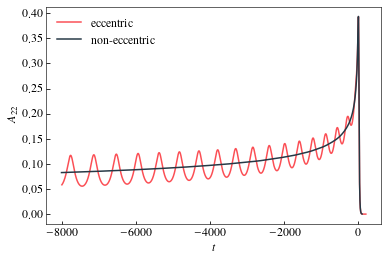

In [9]:
plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label="eccentric")
plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]), label="non-eccentric")
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$A_{22}$")

#### Measure at a single time

In [10]:
tref_in = -5500
for method in get_available_methods():
    tref_out, ecc_ref, meanAno_ref = measure_eccentricity(tref_in=tref_in,
                                                         method=method,
                                                         dataDict=dataDict,
                                                         extra_kwargs={"debug": False})
    print(f"{method:20s}", f"{ecc_ref:.10f}", f"{meanAno_ref:.10f}")

Amplitude            0.1784605520 4.9150099733
Frequency            0.1784357809 4.9159228513
ResidualAmplitude    0.1784870190 4.9194417739
ResidualFrequency    0.1784894958 4.9214723879
FrequencyFits        0.1785157246 4.9212318026


#### Measure at a single frequency

In [12]:
fref_in = 0.005
for method in get_available_methods():
    fref_out, ecc_ref, meanAno_ref = measure_eccentricity(fref_in=fref_in,
                                                         method=method,
                                                         dataDict=dataDict,
                                                         extra_kwargs={"debug": False})
    print(f"{method:20s}", f"{ecc_ref:.10f}", f"{meanAno_ref:.10f}")

Amplitude            0.1716085706 5.0257598444
Frequency            0.1716024933 5.0225337580
ResidualAmplitude    0.1716282030 5.0303007649
ResidualFrequency    0.1716334686 5.0358984865
FrequencyFits        0.1716269601 5.0352866179


**NOTE:** In the similar way, one can measure the eccentricity and mean anomaly at an array of times/frequencies also.

### Making diagnostic plots

The library comes with useful way to make diagnostic plots when the resulting eccentricty does not look good. Each of the plots could be used to investigate different issues that might be causing the unwanted features in the measured eccentricity.

For demonstration purpose, let's try measuring the eccentricity at an array of times using only `ResidualAmplitude` method

In [14]:
tref_in = dataDict["t"]

The diagnostic plots are available through the eccentricity measurement module object. Therefore, we return this object this time as well

In [15]:
method = "ResidualAmplitude"
tref_out, ecc_ref, meanAno_ref, eccMethod = measure_eccentricity(tref_in=tref_in,
                                                                 method=method,
                                                                 dataDict=dataDict,
                                                                 return_ecc_method=True,
                                                                 extra_kwargs={"debug": False})

/home/arif/miniconda3/envs/ecc/lib/python3.9/site-packages/gw_eccentricity/eccDefinition.py:463: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


(-0.00038296915510739257, 0.16)

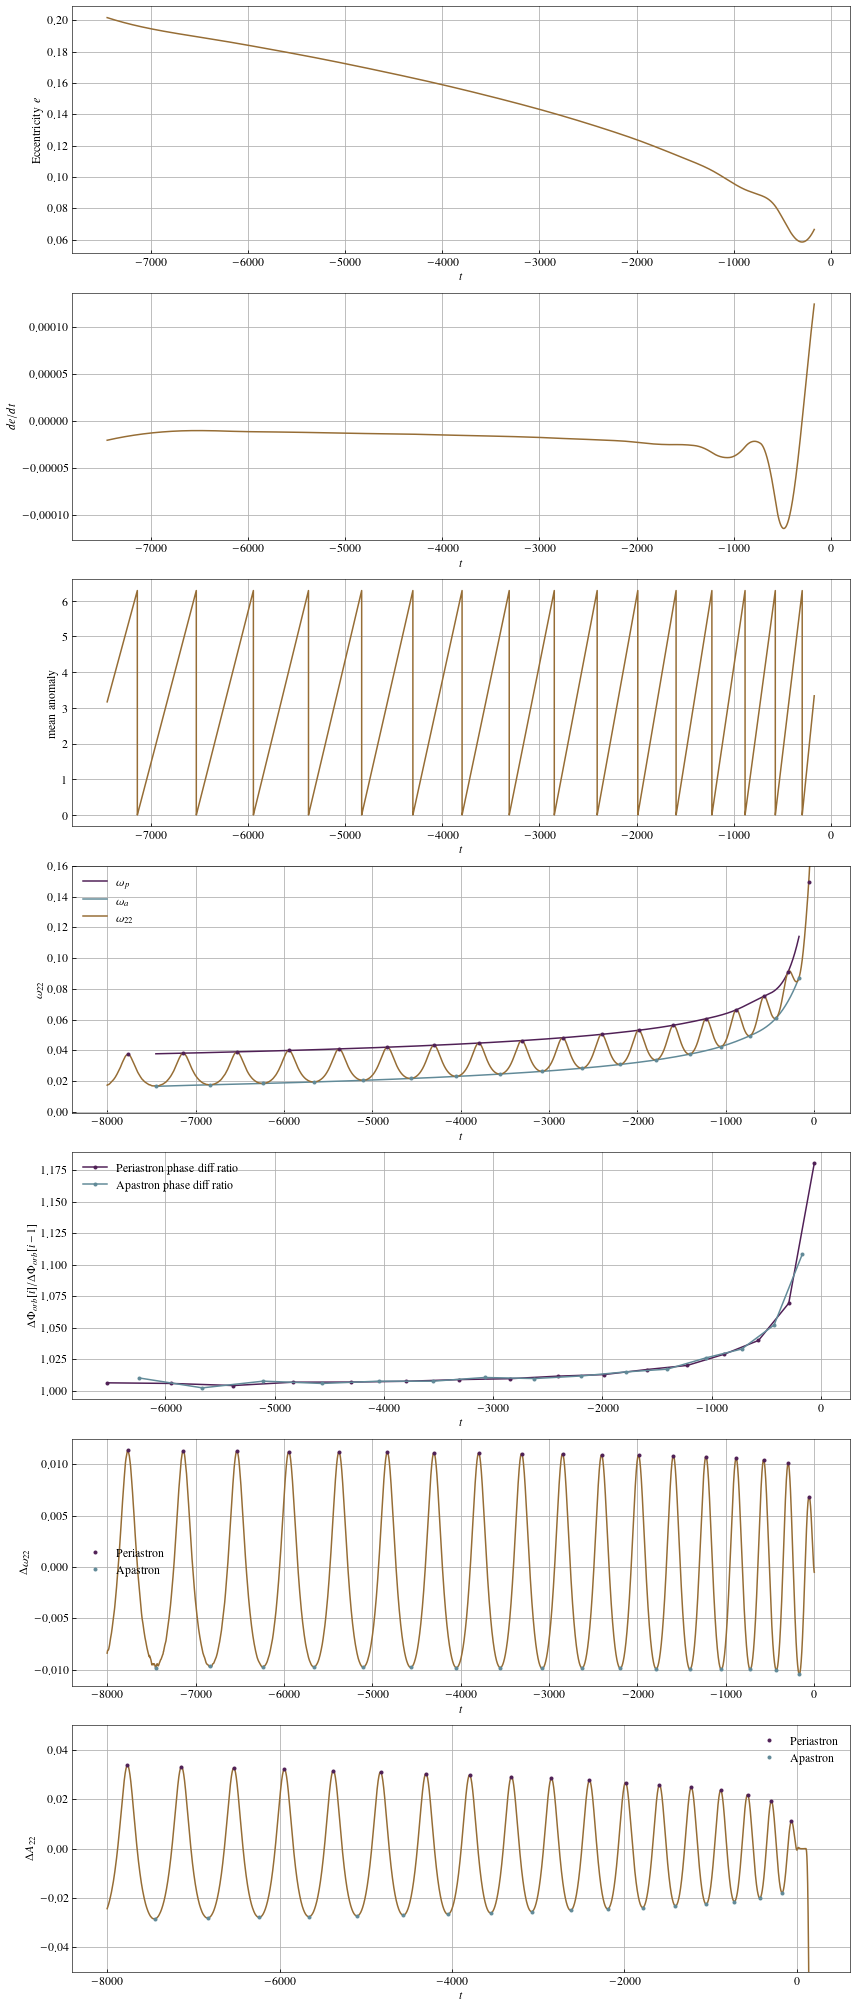

In [18]:
fig, ax = eccMethod.make_diagnostic_plots()
ax[6].set_ylim(-0.05, 0.05)
ax[3].set_ylim(top=0.16)